# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Quality-control" data-toc-modified-id="Quality-control-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quality control</a></div><div class="lev2 toc-item"><a href="#Plot-showing-normal-nhr-57-expression-patterns-in-hypoxia-mutants" data-toc-modified-id="Plot-showing-normal-nhr-57-expression-patterns-in-hypoxia-mutants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plot showing normal <em>nhr-57</em> expression patterns in hypoxia mutants</a></div><div class="lev1 toc-item"><a href="#Quality-Control-on-the-hypoxia-response-and-the-hif-1-direct-target-predictions" data-toc-modified-id="Quality-Control-on-the-hypoxia-response-and-the-hif-1-direct-target-predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quality Control on the hypoxia response and the hif-1 direct target predictions</a></div>

In this notebook, we present some basic sanity checks that our RNA-seq worked and that the data is picking up on the right signals. It's a fairly short notebook. 

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# morgan
import morgan as morgan
import gvars
import genpy

# stats
from scipy import stats as sts

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}

sns.set(style='dark', context='notebook', font='sans-serif')

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
# import the code <--> genotype mapping and other useful variables
genvar = gvars.genvars()

tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')
hypoxia_response = pd.read_csv('../output/temp_files/hypoxia_response.csv')
# fname = '../output/medium_confidence_hypoxia_targets_candidates.csv'
# hypoxia_direct_targets = pd.read_csv(fname)

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

In [4]:
tidy = pd.read_csv('../output/temp_files/DE_genes.csv')
tidy.sort_values('target_id', inplace=True)
tidy.dropna(subset=['ens_gene'], inplace=True)
# drop the fog-2 dataset
tidy = tidy[tidy.code != 'g']
tidy['fancy genotype'] = tidy.code.map(genvar.fancy_mapping)

# Quality control

*egl-9*, *rhy-1* and *nhr-57* are known to be HIF-1 responsive. Let's see if our RNA-seq experiment can recapitulate these known interactions. For ease of viewing, we will plot these results as bar-charts, as if they were qPCR results. To do this, we must select what genes we will use for our quality check. I would like to take a look at *nhr-57*, since this gene is known to be incredibly up-regulated during hypoxia. If N2 worms became hypoxic during treatment for a period long enough to induce transcriptional changes, then *nhr-57* should appear to be significantly down-regulated in the *hif-1* and *egl-9 hif-1* genotypes. 

In [5]:
x = ['WBGene00012324', 'F22E12.4a.1',
     'WBGene00003647', 'WBGene00002248']

find_x = ((tidy.ens_gene.isin(x)) | (tidy.target_id.isin(x)))
plot_df = tidy[find_x].copy()
# plot_df = plot_df[(plot_df.code.isin(['b', 'c', 'f'])) & (plot_df.ext_gene == 'nhr-57')]
x_sort = {'WBGene00012324': 1, 'WBGene00001178': 2,
     'WBGene00003647': 3, 'WBGene00002248': 4}

plot_df['order'] = plot_df.ens_gene.map(x_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

## Plot showing normal *nhr-57* expression patterns in hypoxia mutants

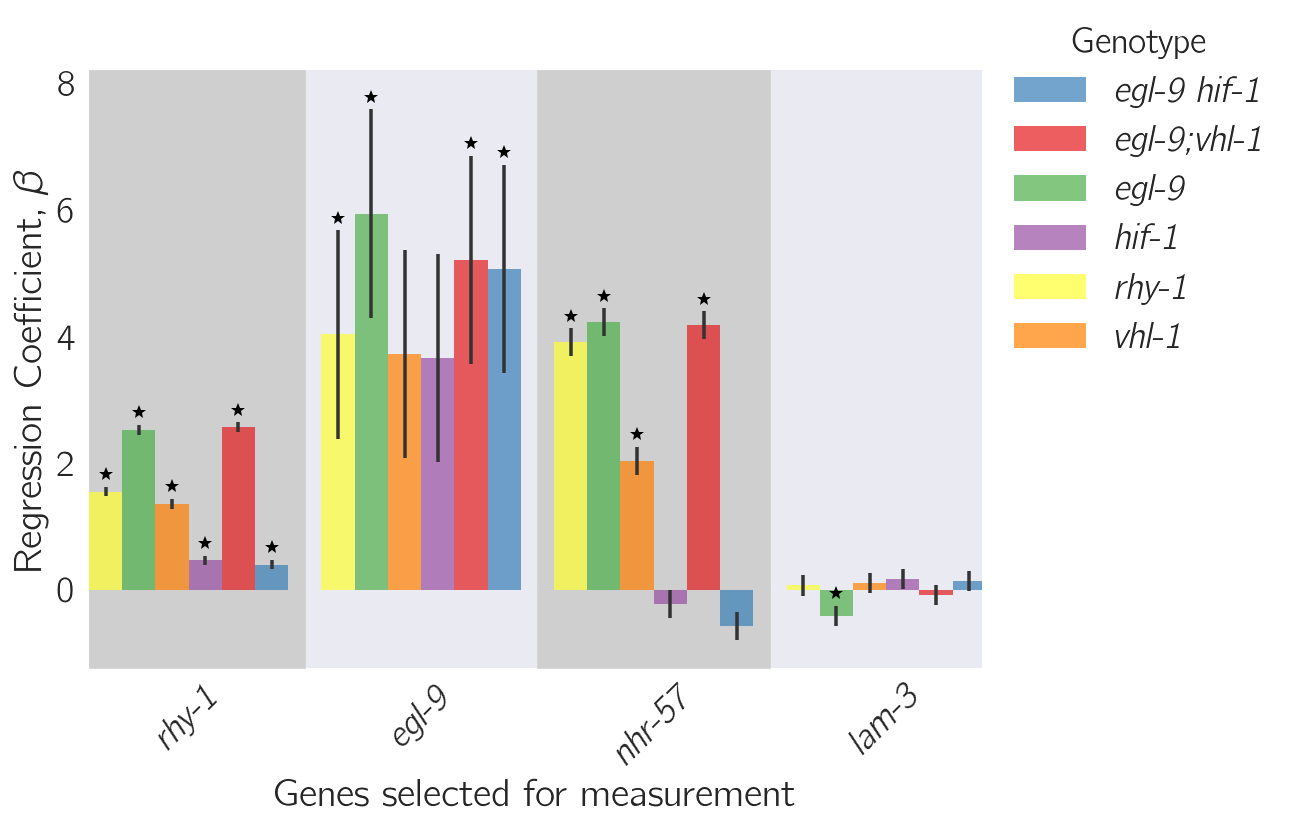

In [6]:
genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color,
                clustering='fancy genotype', plotting_group='ens_gene', rotation=45)
plt.xlabel(r'Genes selected for measurement', fontsize=20)
save = '../output/supp_figures/supplementary_figure_1.svg'
plt.savefig(save, bbox_inches='tight')

It looks like we are able to recapitulate most of the known interactions between these reporters and HIF-1 levels. There are no contradicting results, although the *egl-9* levels don't all quite reach statistical significance. For completeness, below I show ALL the *egl-9* isoforms. 

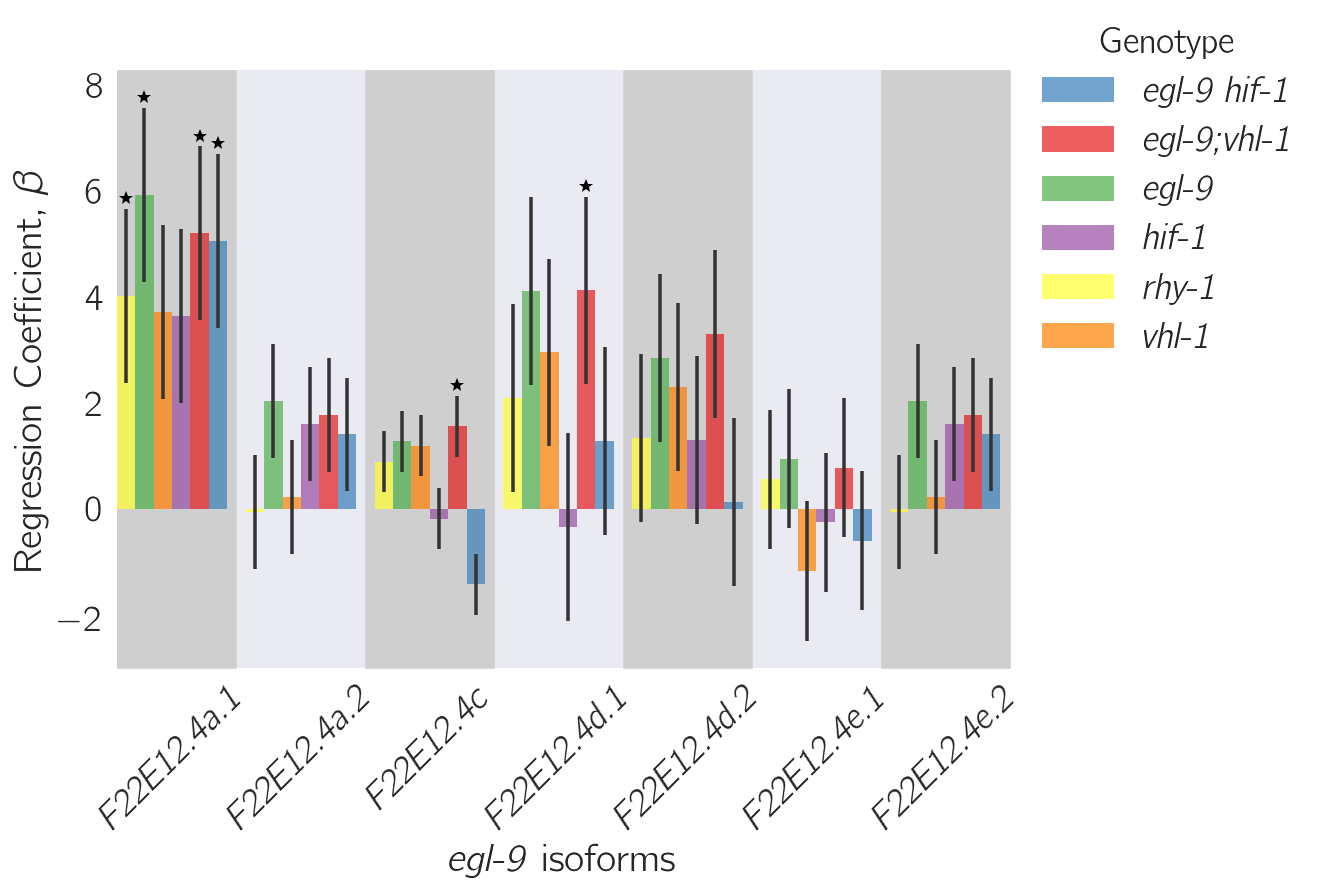

In [7]:
x = ['WBGene00001178']

find_x = tidy.ens_gene.isin(x)
plot_df = tidy[find_x].copy()

x_sort = {}
for i, target in enumerate(plot_df.target_id.unique()):
    x_sort[target] = i + 1

plot_df['order'] = plot_df.target_id.map(x_sort)
plot_df.sort_values('order', inplace=True)
plot_df.reset_index(inplace=True)  

genpy.qPCR_plot(plot_df, genvar.plot_order, genvar.plot_color,
                clustering='fancy genotype', plotting_group='target_id', rotation=45)
plt.xlabel(r'\emph{egl-9} isoforms', fontsize=20)



# Quality Control on the hypoxia response and the hif-1 direct target predictions

That's one way to check the quality of our RNA-seq. Another way is to look for what genes are D.E. in our hypoxia dataset. We will test the most conservative guess for the hypoxia response, and the predicted hypoxia targets using a hypergeometric test. 

In [8]:
q = 0.1
def test_significance(df, gold=hypoxia_gold):
    ind = df.ens_gene.isin(hypoxia_gold.WBIDS)
    found = df[ind].ens_gene.unique()
    sig = len(df.ens_gene.unique())  # number of genes that we picked
    ntotal = len(tidy.ens_gene.unique())  # total genes measured
    pval = sts.hypergeom.sf(len(found), ntotal,
                            len(hypoxia_gold), sig)    
    if pval < 10**-3:
        print('This result is statistically significant' +\
              ' with a p-value of {0:.2g} using a hypergeometric test. '.format(pval) +\
              'You found {0} gold standard genes!'.format(len(found)))
    else:
        print(pval)

Hypoxia response (conservative guess):

In [9]:
test_significance(hypoxia_response)

This result is statistically significant with a p-value of 7.6e-06 using a hypergeometric test. You found 9 gold standard genes!


Both datasets are enriched for known hypoxic response genes!